<a href="https://colab.research.google.com/github/brandiegriffin83/brandiegriffin83/blob/main/L09_Diffusion_student_notebook_ITAI_2376.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [ ]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [ ]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [ ]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
print("MNIST dataset loaded successfully!")

# Validate GPU memory requirements
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    if gpu_memory < 2:
        print("Warning: GPU memory below 2GB. MNIST may still work but monitor usage.")
    else:
        print(f"GPU memory available: {gpu_memory:.2f} GB - Sufficient for MNIST.")
else:
    print("No GPU available. Training will be slower on CPU.")

# Check sample batch properties
sample_loader = DataLoader(dataset, batch_size=1, shuffle=True)
sample_batch = next(iter(sample_loader))
images, labels = sample_batch
print(f"Sample batch shape: {images.shape}")
print(f"Sample data type: {images.dtype}")
print(f"Value range: [{images.min().item():.2f}, {images.max().item():.2f}]")

# Split into train (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)  # SEED = 42 from earlier in lab
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)

# Create DataLoaders
num_workers = min(2, os.cpu_count())  # Colab typically has 2 cores
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# Confirm dataset configuration
print(f"MNIST dataset configured: {len(train_dataset)} train, {len(val_dataset)} val samples.")

#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the Fashion-MNIST dataset
# Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# Enter your code here:

"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

# Your code to create the transform and load CIFAR-10
# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Then load torchvision.datasets.CIFAR10

# Enter your code here:

"""

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 521kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.13MB/s]


MNIST dataset loaded successfully!
GPU memory available: 15.83 GB - Sufficient for MNIST.
Sample batch shape: torch.Size([1, 1, 28, 28])
Sample data type: torch.float32
Value range: [-1.00, 0.99]
MNIST dataset configured: 48000 train, 12000 val samples.


'\nIMG_SIZE = 32\nIMG_CH = 3\nN_CLASSES = 10\nBATCH_SIZE = 32  # Reduced batch size for memory\nEPOCHS = 50      # More epochs for complex data\n\n# Your code to create the transform and load CIFAR-10\n# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n# Then load torchvision.datasets.CIFAR10\n\n# Enter your code here:\n\n'

In [ ]:
# Validating Dataset Selection
# Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Your code to validate GPU memory requirements
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert bytes to GB
    if gpu_memory < 2:
        print("⚠️ Warning: GPU memory below 2GB. MNIST may still work but monitor usage.")
    else:
        print(f"✅ GPU memory available: {gpu_memory:.2f} GB - Sufficient for MNIST.")
else:
    print("⚠️ No GPU available. Training will be slower on CPU. Consider enabling GPU in Colab.")

✅ GPU memory available: 15.83 GB - Sufficient for MNIST.


In [ ]:
# Dataset Properties and Data Loaders
# Now let's examine our dataset
# and set up the data loaders:

sample_loader = DataLoader(dataset, batch_size=1, shuffle=True)
sample_batch = next(iter(sample_loader))
images, labels = sample_batch
print(f"Sample batch shape: {images.shape}")
print(f"Sample data type: {images.dtype}")
print(f"Value range: [{images.min().item():.2f}, {images.max().item():.2f}]")


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)

num_workers = min(2, os.cpu_count())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print(f"DataLoaders configured: {len(train_dataloader)} train batches, {len(val_dataloader)} val batches")

Sample batch shape: torch.Size([1, 1, 28, 28])
Sample data type: torch.float32
Value range: [-1.00, 1.00]
DataLoaders configured: 750 train batches, 188 val batches


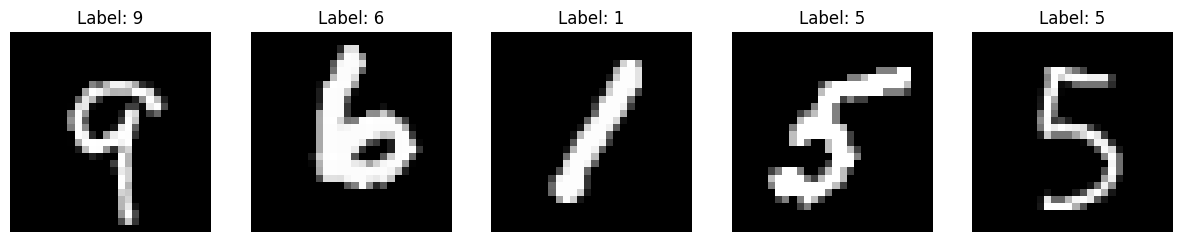

In [ ]:
# Visualize a few MNIST samples
def show_images(images, labels, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i].numpy().squeeze()
        img = img * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)
show_images(images, labels)

## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [ ]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        self.conv = GELUConvBlock(in_chs * 4, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [ ]:
# Let's implement the downsampling block for our U-Net architecture:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        return self.model(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)  # Upsample before concatenation
        self.conv_blocks = nn.Sequential(
            GELUConvBlock(in_chs + out_chs, in_chs, group_size),  # Updated: in_chs + out_chs instead of in_chs * 2
            GELUConvBlock(in_chs, out_chs, group_size)
        )
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        x = self.up(x)  # Upsample x first to match skip's spatial dimensions
        x = torch.cat([x, skip], dim=1)  # Now x and skip have the same spatial dimensions
        return self.conv_blocks(x)

In [ ]:
# Here we implement the time embedding block for our U-Net architecture:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [ ]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, c_embed_dim):
        super().__init__()
        self.t_embed_dim = down_chs[-1]  # Derive t_embed_dim from down_chs[-1]
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(self.t_embed_dim),
            nn.Linear(self.t_embed_dim, self.t_embed_dim),
            nn.GELU()
        )
        self.class_embed = EmbedBlock(c_embed_dim, down_chs[-1])  # Output matches down_chs[-1]
        self.initial_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)
        self.downs = nn.ModuleList([
            DownBlock(down_chs[i], down_chs[i+1], group_size=8)
            for i in range(len(down_chs)-1)
        ])
        self.middle = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8),
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8)
        )
        self.ups = nn.ModuleList([
            UpBlock(down_chs[i+1], down_chs[i], group_size=8)
            for i in range(len(down_chs)-2, -1, -1)
        ])
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)
        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        t_emb = self.time_embed(t)
        t_emb = t_emb.view(-1, self.t_embed_dim, 1, 1)
        c_emb = self.class_embed(c)
        c_emb = c_emb * c_mask.view(-1, 1, 1, 1)
        x = self.initial_conv(x)
        skips = [x]
        for down in self.downs:
            x = down(x)
            skips.append(x)
        skips = skips[:-1][::-1]
        x = self.middle(x)
        x = x + t_emb + c_emb
        for up, skip in zip(self.ups, skips):
            x = up(x, skip)
        return self.final_conv(x)

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [ ]:
# Set up the noise schedule
n_steps = 100
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

In [ ]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()
def remove_noise(x_t, t, model, c, c_mask):
    predicted_noise = model(x_t, t, c, c_mask)
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    if t[0] == 0:
        return x_t
    else:
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(beta_t) * noise

In [ ]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()
def remove_noise(x_t, t, model, c, c_mask):
    predicted_noise = model(x_t, t, c, c_mask)
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)

    # Calculate sqrt_one_minus_alpha_bar_t here
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    if t[0] == 0:
        return x_t
    else:
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(beta_t) * noise

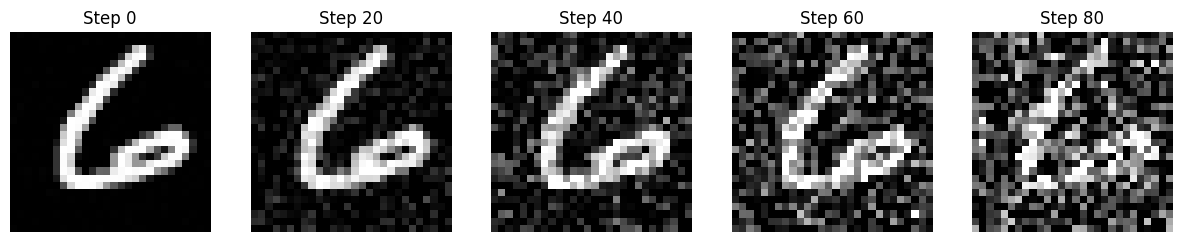

'\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps)**2\nalpha_alt = 1 - beta_alt\nalpha_bar_alt = torch.cumprod(alpha_alt, dim=0)\n'

In [ ]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    plt.figure(figsize=(15, 3))
    step_size = n_steps // num_steps
    for i in range(num_steps):
        t_idx = i * step_size
        t = torch.tensor([t_idx]).to(device)
        noisy_image, _ = add_noise(image.unsqueeze(0), t)
        plt.subplot(1, num_steps, i+1)
        img = noisy_image[0].cpu().numpy().squeeze()
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Step {t_idx}')
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_dataloader))
sample_image = sample_batch[0][0].to(device)
show_noise_progression(sample_image)

# Student Activity: Try different noise schedules
"""
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)
"""

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [ ]:
# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    down_chs=(32, 64, 128),
    c_embed_dim=N_CLASSES
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Set up the optimizer with parameters tuned for diffusion models
initial_lr = 0.001
weight_decay = 1e-5

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

Created DownBlock: in_chs=32, out_chs=64, spatial_reduction=2x
Created DownBlock: in_chs=64, out_chs=128, spatial_reduction=2x
Created UpBlock: in_chs=128, out_chs=64, spatial_increase=2x
Created UpBlock: in_chs=64, out_chs=32, spatial_increase=2x
Created UNet with 3 scale levels
Channel dimensions: (32, 64, 128)

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            samples.append(x)

        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

        plt.figure(figsize=(10, 4))

        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())

        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }

        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")

In [ ]:
# Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Pick random timesteps for each image in the batch
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    x_t, noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    loss = F.mse_loss(predicted_noise, noise)
    return loss


STARTING TRAINING

Epoch 1/30
--------------------
  Step 0/750, Loss: 1.3369
  Step 100/750, Loss: 0.1086
  Step 200/750, Loss: 0.0987
  Step 300/750, Loss: 0.0904
  Step 400/750, Loss: 0.0798
  Step 500/750, Loss: 0.0700
  Generating samples...


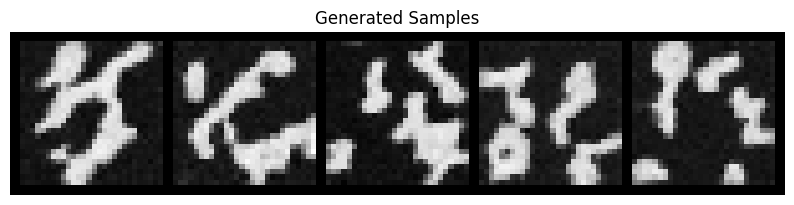

  Step 600/750, Loss: 0.0791
  Step 700/750, Loss: 0.0797

Training - Epoch 1 average loss: 0.1005
Running validation...
Validation - Epoch 1 average loss: 0.0765
Learning rate: 0.001000

Generating samples for visual progress check...


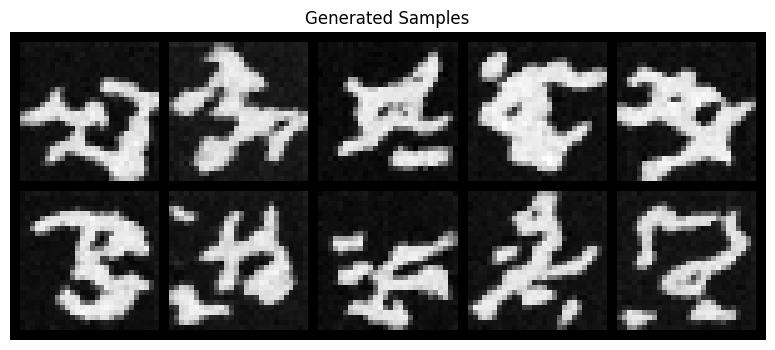

Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0765)


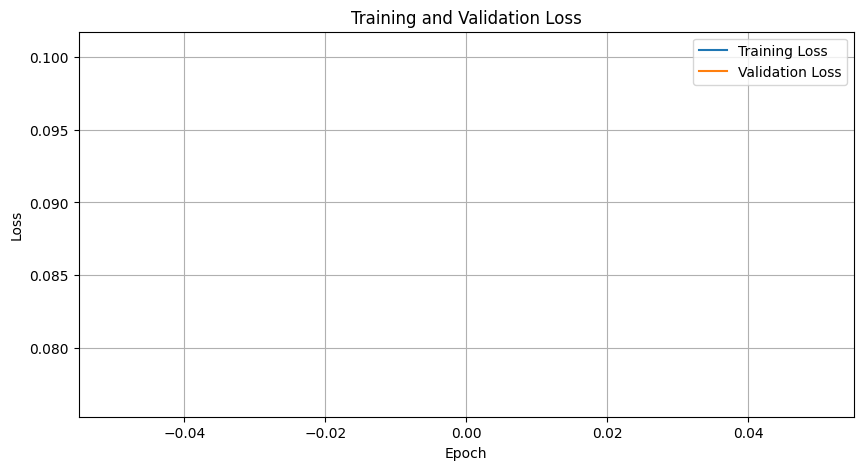


Epoch 2/30
--------------------
  Step 0/750, Loss: 0.0949
  Step 100/750, Loss: 0.0772
  Step 200/750, Loss: 0.0638
  Step 300/750, Loss: 0.0738
  Step 400/750, Loss: 0.0709
  Step 500/750, Loss: 0.0653
  Generating samples...


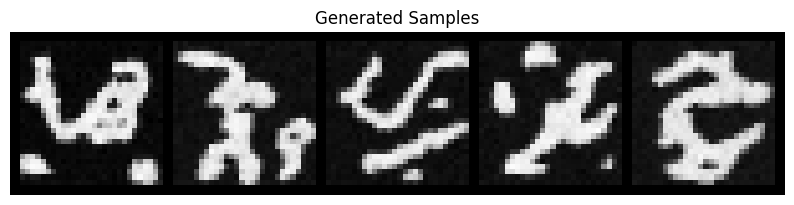

  Step 600/750, Loss: 0.0702
  Step 700/750, Loss: 0.0647

Training - Epoch 2 average loss: 0.0711
Running validation...
Validation - Epoch 2 average loss: 0.0656
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0656)

Epoch 3/30
--------------------
  Step 0/750, Loss: 0.0723
  Step 100/750, Loss: 0.0682
  Step 200/750, Loss: 0.0600
  Step 300/750, Loss: 0.0590
  Step 400/750, Loss: 0.0758
  Step 500/750, Loss: 0.0700
  Generating samples...


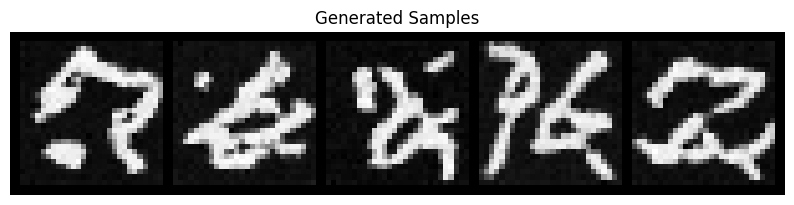

  Step 600/750, Loss: 0.0586
  Step 700/750, Loss: 0.0679

Training - Epoch 3 average loss: 0.0652
Running validation...
Validation - Epoch 3 average loss: 0.0626
Learning rate: 0.001000

Generating samples for visual progress check...


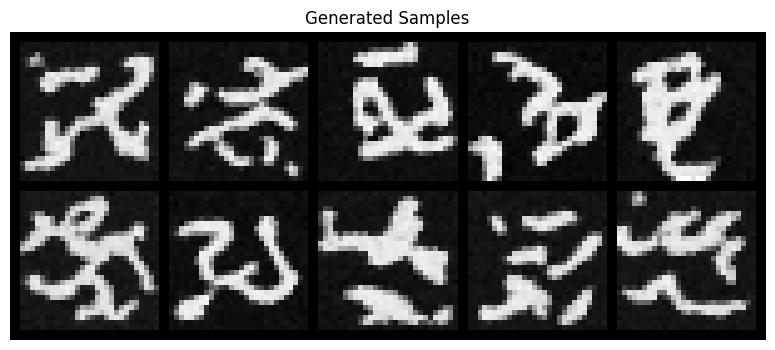

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0626)

Epoch 4/30
--------------------
  Step 0/750, Loss: 0.0616
  Step 100/750, Loss: 0.0602
  Step 200/750, Loss: 0.0627
  Step 300/750, Loss: 0.0648
  Step 400/750, Loss: 0.0572
  Step 500/750, Loss: 0.0590
  Generating samples...


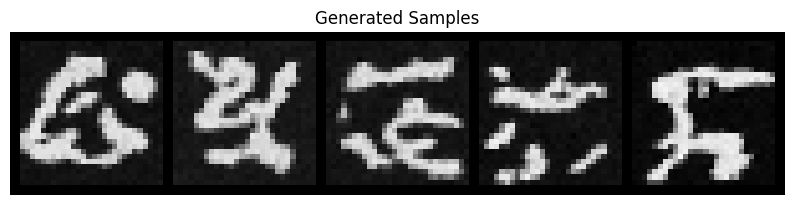

  Step 600/750, Loss: 0.0613
  Step 700/750, Loss: 0.0599

Training - Epoch 4 average loss: 0.0634
Running validation...
Validation - Epoch 4 average loss: 0.0614
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0614)

Epoch 5/30
--------------------
  Step 0/750, Loss: 0.0660
  Step 100/750, Loss: 0.0588
  Step 200/750, Loss: 0.0582
  Step 300/750, Loss: 0.0545
  Step 400/750, Loss: 0.0808
  Step 500/750, Loss: 0.0693
  Generating samples...


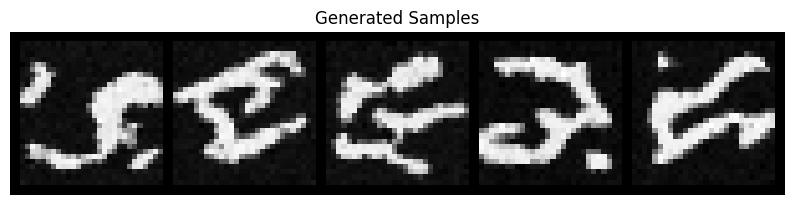

  Step 600/750, Loss: 0.0598
  Step 700/750, Loss: 0.0505

Training - Epoch 5 average loss: 0.0615
Running validation...
Validation - Epoch 5 average loss: 0.0601
Learning rate: 0.001000

Generating samples for visual progress check...


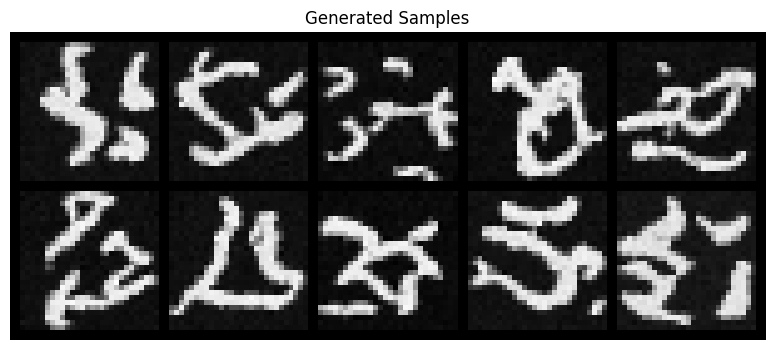

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0601)

Epoch 6/30
--------------------
  Step 0/750, Loss: 0.0594
  Step 100/750, Loss: 0.0615
  Step 200/750, Loss: 0.0560
  Step 300/750, Loss: 0.0638
  Step 400/750, Loss: 0.0782
  Step 500/750, Loss: 0.0580
  Generating samples...


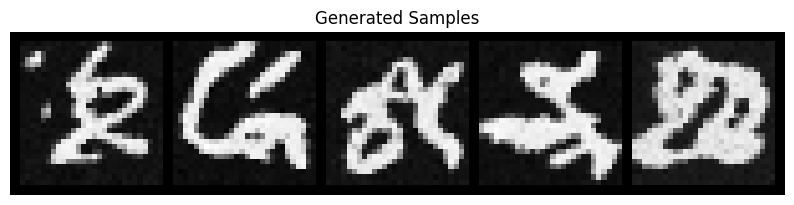

  Step 600/750, Loss: 0.0673
  Step 700/750, Loss: 0.0612

Training - Epoch 6 average loss: 0.0609
Running validation...
Validation - Epoch 6 average loss: 0.0597
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0597)


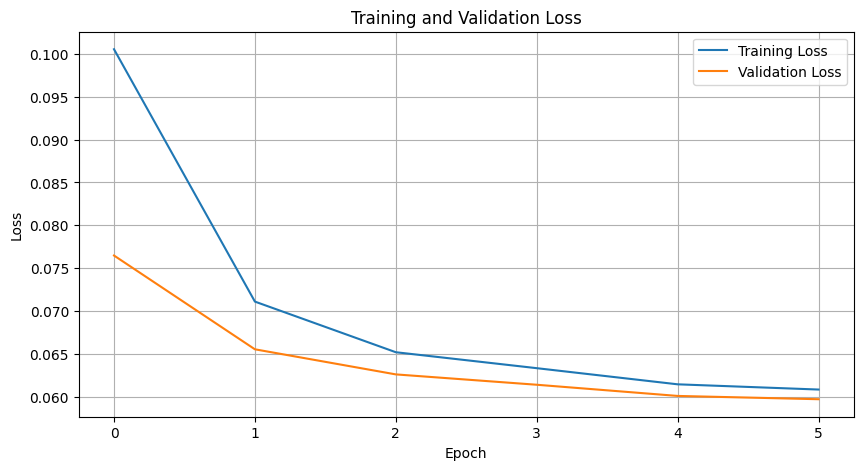


Epoch 7/30
--------------------
  Step 0/750, Loss: 0.0585
  Step 100/750, Loss: 0.0552
  Step 200/750, Loss: 0.0578
  Step 300/750, Loss: 0.0556
  Step 400/750, Loss: 0.0635
  Step 500/750, Loss: 0.0608
  Generating samples...


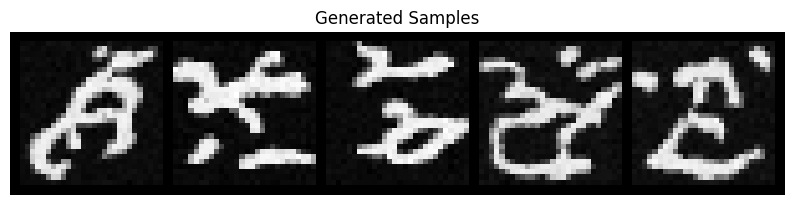

  Step 600/750, Loss: 0.0563
  Step 700/750, Loss: 0.0545

Training - Epoch 7 average loss: 0.0600
Running validation...
Validation - Epoch 7 average loss: 0.0589
Learning rate: 0.001000

Generating samples for visual progress check...


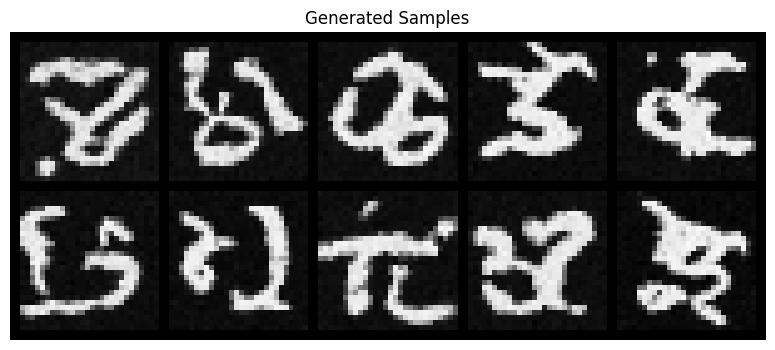

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0589)

Epoch 8/30
--------------------
  Step 0/750, Loss: 0.0597
  Step 100/750, Loss: 0.0614
  Step 200/750, Loss: 0.0552
  Step 300/750, Loss: 0.0669
  Step 400/750, Loss: 0.0634
  Step 500/750, Loss: 0.0625
  Generating samples...


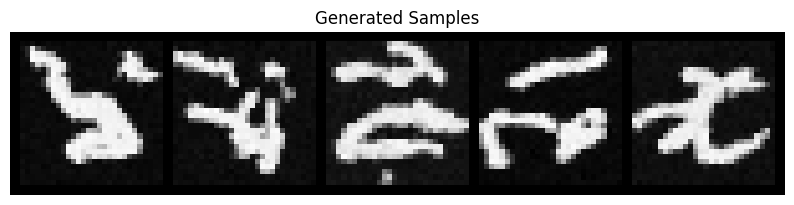

  Step 600/750, Loss: 0.0539
  Step 700/750, Loss: 0.0537

Training - Epoch 8 average loss: 0.0592
Running validation...
Validation - Epoch 8 average loss: 0.0583
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0583)

Epoch 9/30
--------------------
  Step 0/750, Loss: 0.0573
  Step 100/750, Loss: 0.0565
  Step 200/750, Loss: 0.0490
  Step 300/750, Loss: 0.0603
  Step 400/750, Loss: 0.0545
  Step 500/750, Loss: 0.0549
  Generating samples...


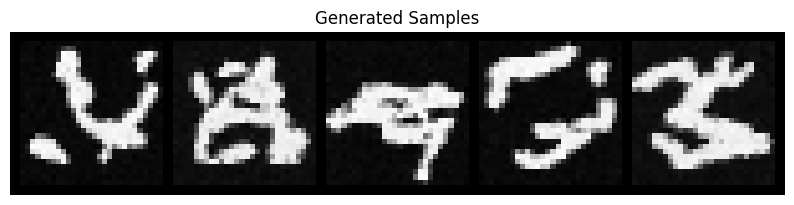

  Step 600/750, Loss: 0.0643
  Step 700/750, Loss: 0.0557

Training - Epoch 9 average loss: 0.0591
Running validation...
Validation - Epoch 9 average loss: 0.0596
Learning rate: 0.001000

Generating samples for visual progress check...


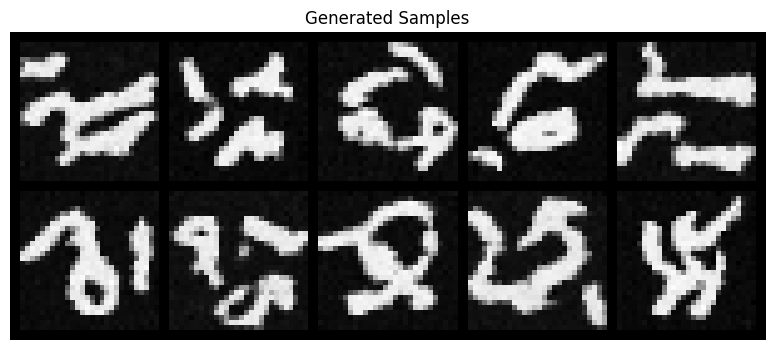

No improvement for 1/10 epochs

Epoch 10/30
--------------------
  Step 0/750, Loss: 0.0687
  Step 100/750, Loss: 0.0613
  Step 200/750, Loss: 0.0567
  Step 300/750, Loss: 0.0596
  Step 400/750, Loss: 0.0513
  Step 500/750, Loss: 0.0597
  Generating samples...


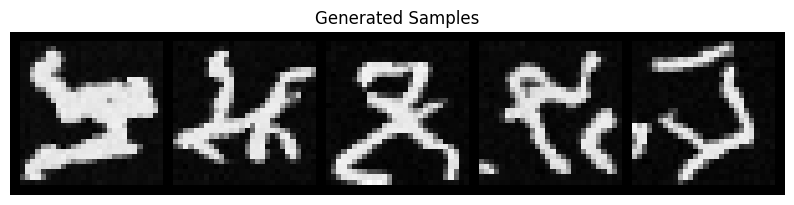

  Step 600/750, Loss: 0.0531
  Step 700/750, Loss: 0.0579

Training - Epoch 10 average loss: 0.0585
Running validation...
Validation - Epoch 10 average loss: 0.0597
Learning rate: 0.001000
No improvement for 2/10 epochs

Epoch 11/30
--------------------
  Step 0/750, Loss: 0.0601
  Step 100/750, Loss: 0.0563
  Step 200/750, Loss: 0.0569
  Step 300/750, Loss: 0.0602
  Step 400/750, Loss: 0.0529
  Step 500/750, Loss: 0.0575
  Generating samples...


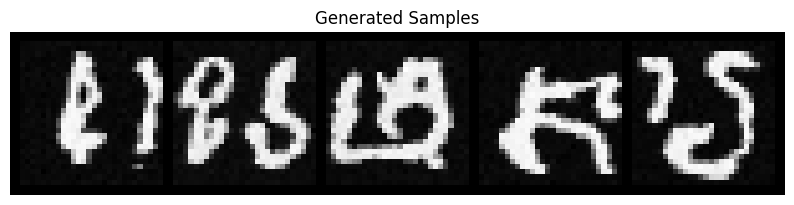

  Step 600/750, Loss: 0.0535
  Step 700/750, Loss: 0.0781

Training - Epoch 11 average loss: 0.0585
Running validation...
Validation - Epoch 11 average loss: 0.0583
Learning rate: 0.001000

Generating samples for visual progress check...


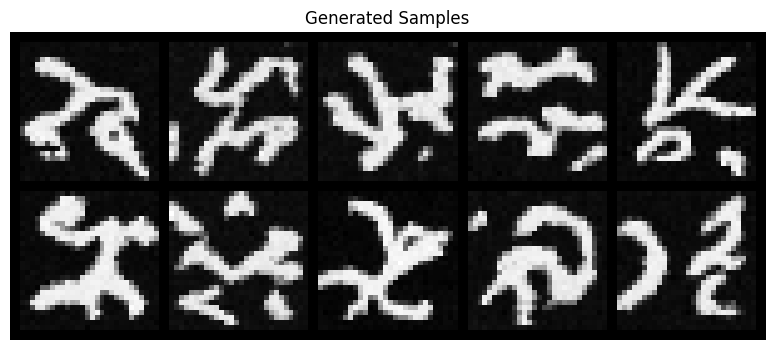

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0583)


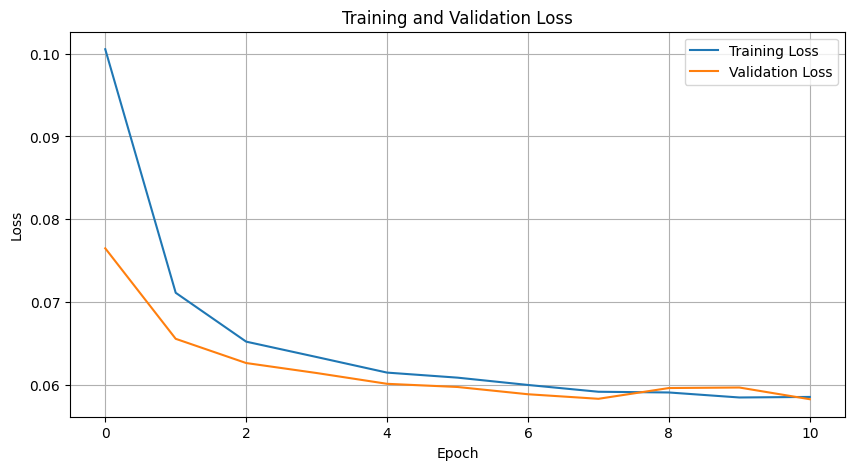


Epoch 12/30
--------------------
  Step 0/750, Loss: 0.0600
  Step 100/750, Loss: 0.0644
  Step 200/750, Loss: 0.0628
  Step 300/750, Loss: 0.0551
  Step 400/750, Loss: 0.0536
  Step 500/750, Loss: 0.0565
  Generating samples...


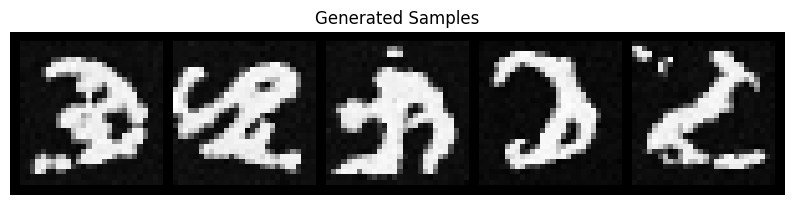

  Step 600/750, Loss: 0.0570
  Step 700/750, Loss: 0.0640

Training - Epoch 12 average loss: 0.0580
Running validation...
Validation - Epoch 12 average loss: 0.0570
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0570)

Epoch 13/30
--------------------
  Step 0/750, Loss: 0.0586
  Step 100/750, Loss: 0.0616
  Step 200/750, Loss: 0.0592
  Step 300/750, Loss: 0.0591
  Step 400/750, Loss: 0.0494
  Step 500/750, Loss: 0.0573
  Generating samples...


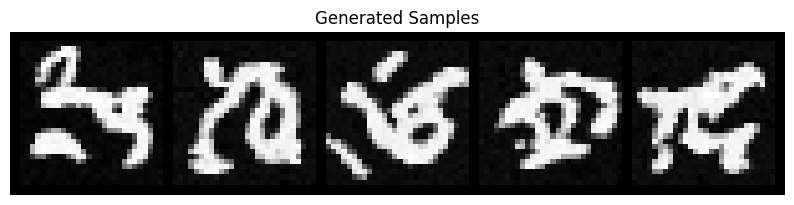

  Step 600/750, Loss: 0.0571
  Step 700/750, Loss: 0.0577

Training - Epoch 13 average loss: 0.0579
Running validation...
Validation - Epoch 13 average loss: 0.0574
Learning rate: 0.001000

Generating samples for visual progress check...


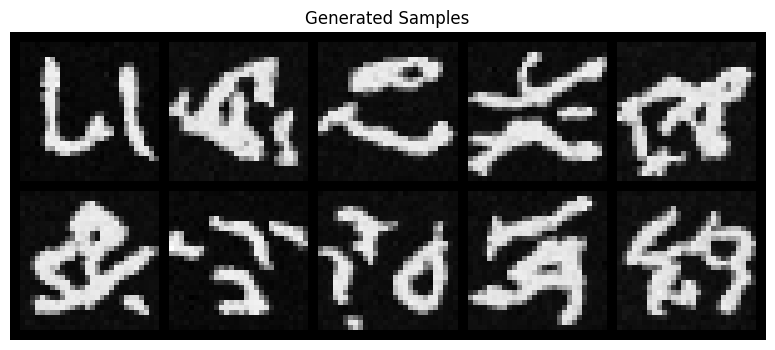

No improvement for 1/10 epochs

Epoch 14/30
--------------------
  Step 0/750, Loss: 0.0515
  Step 100/750, Loss: 0.0543
  Step 200/750, Loss: 0.0613
  Step 300/750, Loss: 0.0569
  Step 400/750, Loss: 0.0502
  Step 500/750, Loss: 0.0623
  Generating samples...


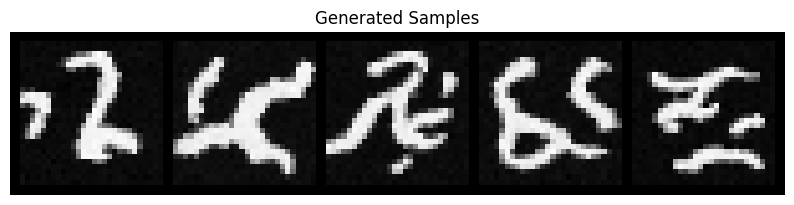

  Step 600/750, Loss: 0.0506
  Step 700/750, Loss: 0.0560

Training - Epoch 14 average loss: 0.0576
Running validation...
Validation - Epoch 14 average loss: 0.0569
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0569)

Epoch 15/30
--------------------
  Step 0/750, Loss: 0.0523
  Step 100/750, Loss: 0.0590
  Step 200/750, Loss: 0.0472
  Step 300/750, Loss: 0.0515
  Step 400/750, Loss: 0.0518
  Step 500/750, Loss: 0.0490
  Generating samples...


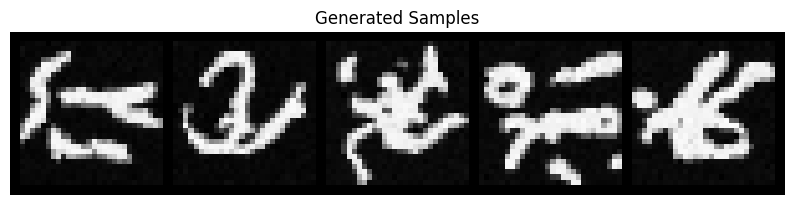

  Step 600/750, Loss: 0.0533
  Step 700/750, Loss: 0.0554

Training - Epoch 15 average loss: 0.0574
Running validation...
Validation - Epoch 15 average loss: 0.0577
Learning rate: 0.001000

Generating samples for visual progress check...


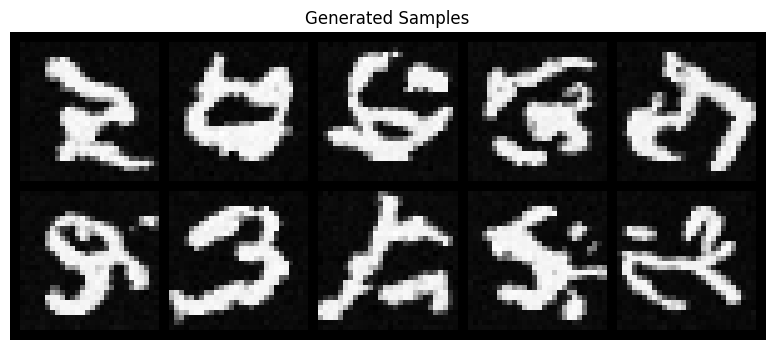

No improvement for 1/10 epochs

Epoch 16/30
--------------------
  Step 0/750, Loss: 0.0504
  Step 100/750, Loss: 0.0616
  Step 200/750, Loss: 0.0591
  Step 300/750, Loss: 0.0579
  Step 400/750, Loss: 0.0570
  Step 500/750, Loss: 0.0615
  Generating samples...


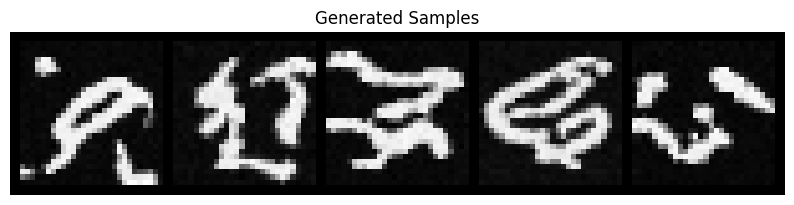

  Step 600/750, Loss: 0.0537
  Step 700/750, Loss: 0.0623

Training - Epoch 16 average loss: 0.0574
Running validation...
Validation - Epoch 16 average loss: 0.0569
Learning rate: 0.001000
No improvement for 2/10 epochs


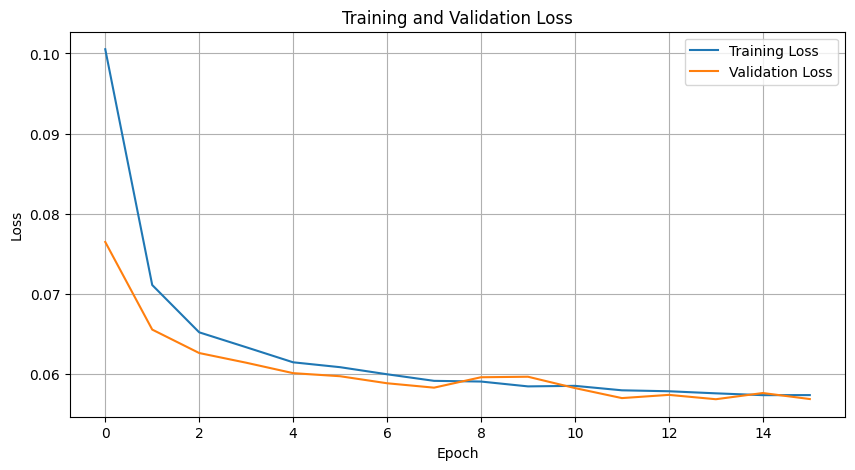


Epoch 17/30
--------------------
  Step 0/750, Loss: 0.0636
  Step 100/750, Loss: 0.0544
  Step 200/750, Loss: 0.0623
  Step 300/750, Loss: 0.0576
  Step 400/750, Loss: 0.0584
  Step 500/750, Loss: 0.0519
  Generating samples...


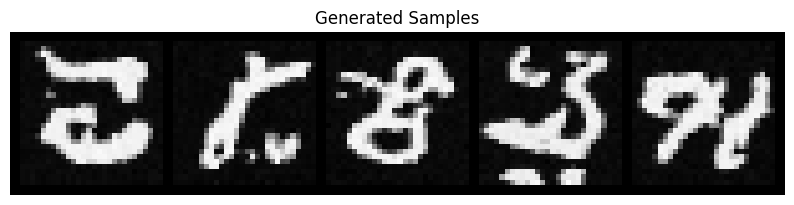

  Step 600/750, Loss: 0.0645
  Step 700/750, Loss: 0.0553

Training - Epoch 17 average loss: 0.0568
Running validation...
Validation - Epoch 17 average loss: 0.0574
Learning rate: 0.001000

Generating samples for visual progress check...


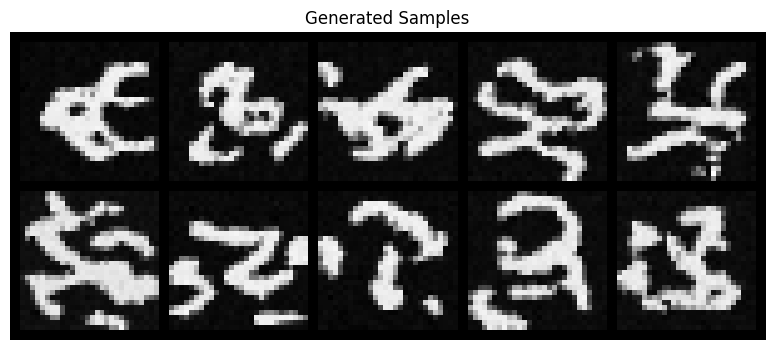

No improvement for 3/10 epochs

Epoch 18/30
--------------------
  Step 0/750, Loss: 0.0628
  Step 100/750, Loss: 0.0589
  Step 200/750, Loss: 0.0548
  Step 300/750, Loss: 0.0626
  Step 400/750, Loss: 0.0551
  Step 500/750, Loss: 0.0538
  Generating samples...


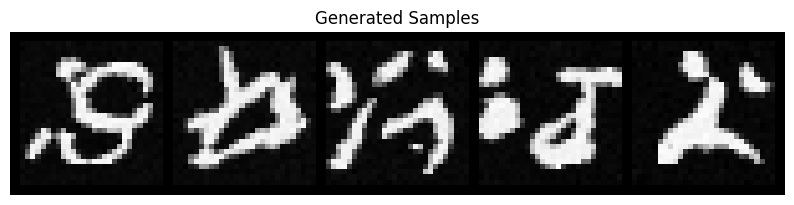

  Step 600/750, Loss: 0.0552
  Step 700/750, Loss: 0.0563

Training - Epoch 18 average loss: 0.0569
Running validation...
Validation - Epoch 18 average loss: 0.0566
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0566)

Epoch 19/30
--------------------
  Step 0/750, Loss: 0.0502
  Step 100/750, Loss: 0.0532
  Step 200/750, Loss: 0.0554
  Step 300/750, Loss: 0.0584
  Step 400/750, Loss: 0.0572
  Step 500/750, Loss: 0.0531
  Generating samples...


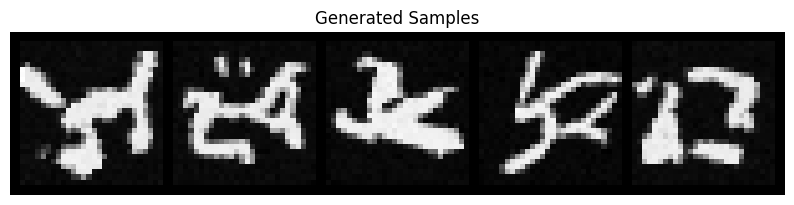

  Step 600/750, Loss: 0.0556
  Step 700/750, Loss: 0.0521

Training - Epoch 19 average loss: 0.0570
Running validation...
Validation - Epoch 19 average loss: 0.0567
Learning rate: 0.001000

Generating samples for visual progress check...


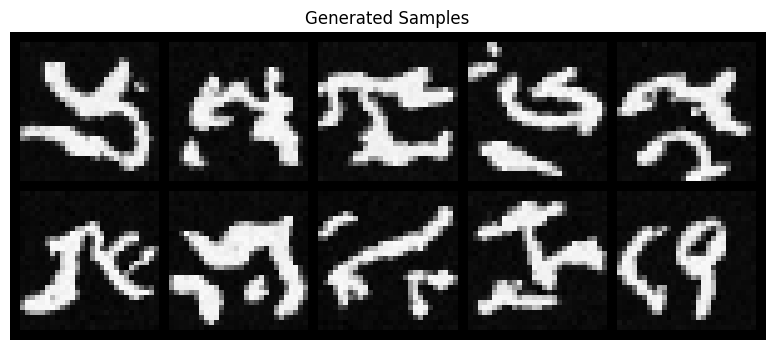

No improvement for 1/10 epochs

Epoch 20/30
--------------------
  Step 0/750, Loss: 0.0581
  Step 100/750, Loss: 0.0489
  Step 200/750, Loss: 0.0578
  Step 300/750, Loss: 0.0575
  Step 400/750, Loss: 0.0531
  Step 500/750, Loss: 0.0590
  Generating samples...


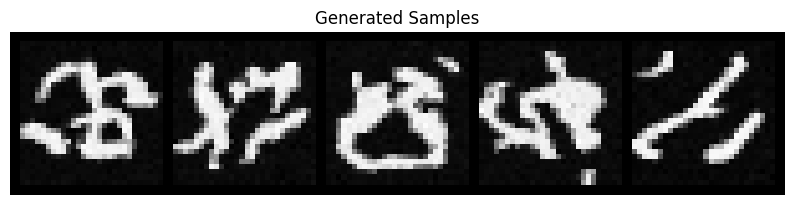

  Step 600/750, Loss: 0.0612
  Step 700/750, Loss: 0.0592

Training - Epoch 20 average loss: 0.0566
Running validation...
Validation - Epoch 20 average loss: 0.0561
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0561)

Epoch 21/30
--------------------
  Step 0/750, Loss: 0.0579
  Step 100/750, Loss: 0.0588
  Step 200/750, Loss: 0.0585
  Step 300/750, Loss: 0.0558
  Step 400/750, Loss: 0.0569
  Step 500/750, Loss: 0.0581
  Generating samples...


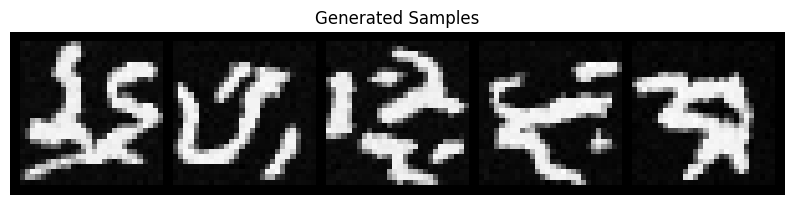

  Step 600/750, Loss: 0.0556
  Step 700/750, Loss: 0.0635

Training - Epoch 21 average loss: 0.0567
Running validation...
Validation - Epoch 21 average loss: 0.0570
Learning rate: 0.001000

Generating samples for visual progress check...


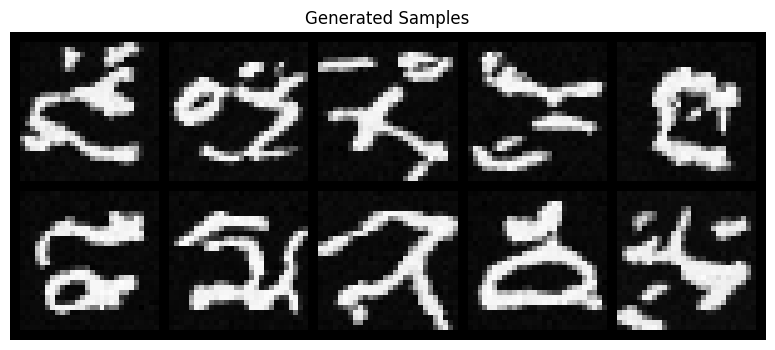

No improvement for 1/10 epochs


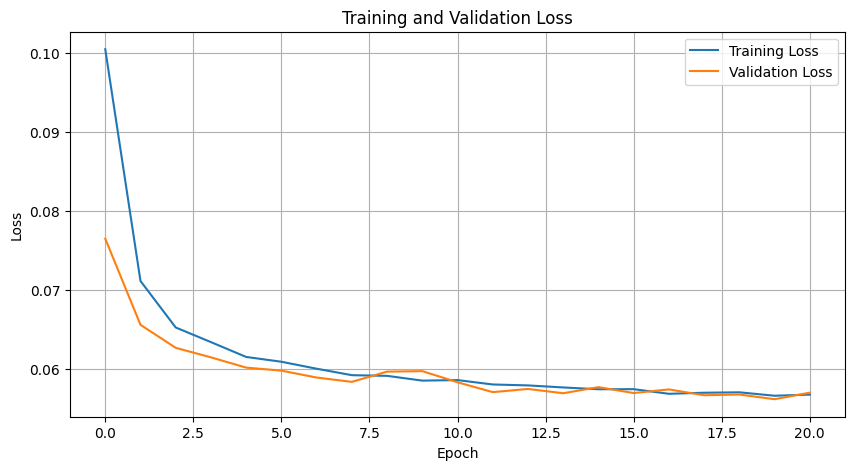


Epoch 22/30
--------------------
  Step 0/750, Loss: 0.0530
  Step 100/750, Loss: 0.0570
  Step 200/750, Loss: 0.0558
  Step 300/750, Loss: 0.0488
  Step 400/750, Loss: 0.0624
  Step 500/750, Loss: 0.0548
  Generating samples...


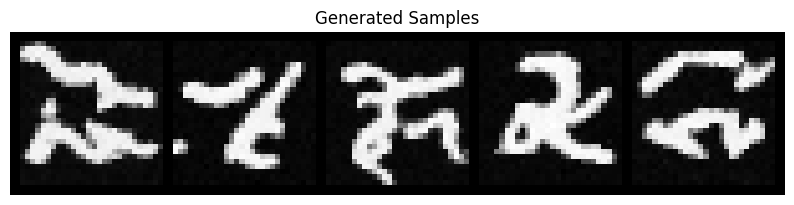

  Step 600/750, Loss: 0.0503
  Step 700/750, Loss: 0.0548

Training - Epoch 22 average loss: 0.0565
Running validation...
Validation - Epoch 22 average loss: 0.0560
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0560)

Epoch 23/30
--------------------
  Step 0/750, Loss: 0.0625
  Step 100/750, Loss: 0.0511
  Step 200/750, Loss: 0.0504
  Step 300/750, Loss: 0.0517
  Step 400/750, Loss: 0.0512
  Step 500/750, Loss: 0.0574
  Generating samples...


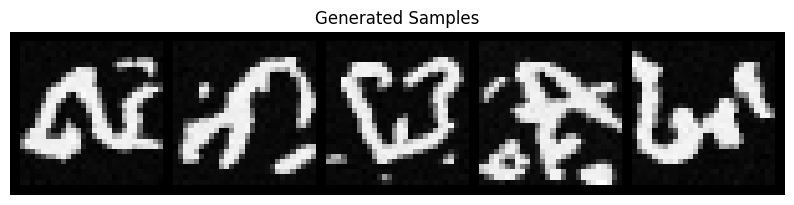

  Step 600/750, Loss: 0.0576
  Step 700/750, Loss: 0.0560

Training - Epoch 23 average loss: 0.0566
Running validation...
Validation - Epoch 23 average loss: 0.0562
Learning rate: 0.001000

Generating samples for visual progress check...


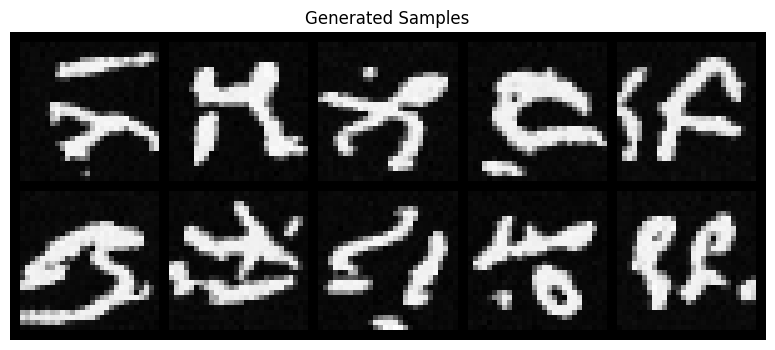

No improvement for 1/10 epochs

Epoch 24/30
--------------------
  Step 0/750, Loss: 0.0596
  Step 100/750, Loss: 0.0717
  Step 200/750, Loss: 0.0586
  Step 300/750, Loss: 0.0587
  Step 400/750, Loss: 0.0694
  Step 500/750, Loss: 0.0574
  Generating samples...


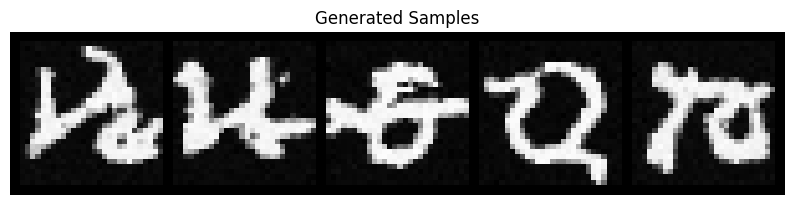

  Step 600/750, Loss: 0.0620
  Step 700/750, Loss: 0.0557

Training - Epoch 24 average loss: 0.0564
Running validation...
Validation - Epoch 24 average loss: 0.0553
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0553)

Epoch 25/30
--------------------
  Step 0/750, Loss: 0.0538
  Step 100/750, Loss: 0.0497
  Step 200/750, Loss: 0.0503
  Step 300/750, Loss: 0.0588
  Step 400/750, Loss: 0.0546
  Step 500/750, Loss: 0.0623
  Generating samples...


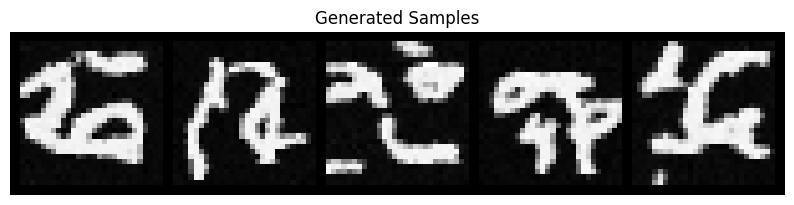

  Step 600/750, Loss: 0.0594
  Step 700/750, Loss: 0.0530

Training - Epoch 25 average loss: 0.0565
Running validation...
Validation - Epoch 25 average loss: 0.0560
Learning rate: 0.001000

Generating samples for visual progress check...


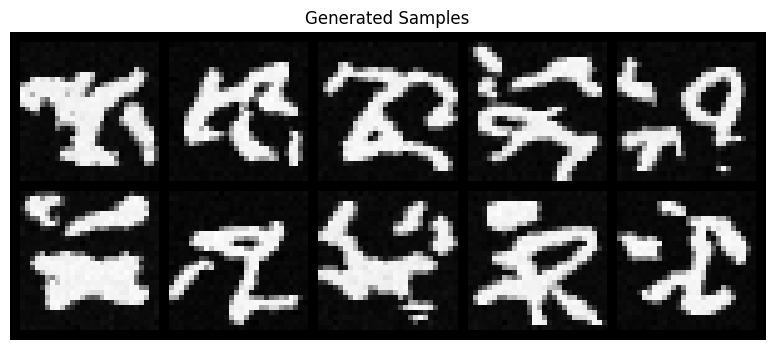

No improvement for 1/10 epochs

Epoch 26/30
--------------------
  Step 0/750, Loss: 0.0541
  Step 100/750, Loss: 0.0597
  Step 200/750, Loss: 0.0541
  Step 300/750, Loss: 0.0561
  Step 400/750, Loss: 0.0588
  Step 500/750, Loss: 0.0532
  Generating samples...


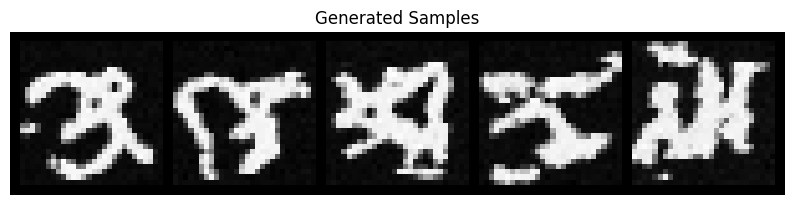

  Step 600/750, Loss: 0.0600
  Step 700/750, Loss: 0.0605

Training - Epoch 26 average loss: 0.0562
Running validation...
Validation - Epoch 26 average loss: 0.0556
Learning rate: 0.001000
No improvement for 2/10 epochs


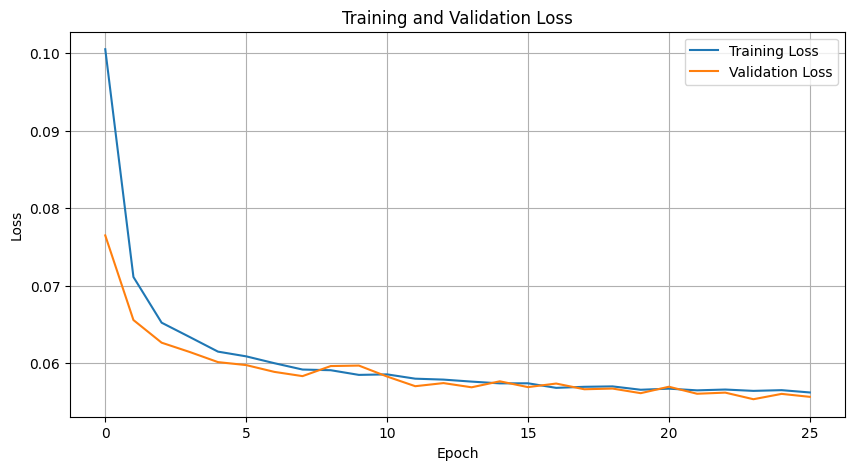


Epoch 27/30
--------------------
  Step 0/750, Loss: 0.0620
  Step 100/750, Loss: 0.0539
  Step 200/750, Loss: 0.0575
  Step 300/750, Loss: 0.0652
  Step 400/750, Loss: 0.0527
  Step 500/750, Loss: 0.0543
  Generating samples...


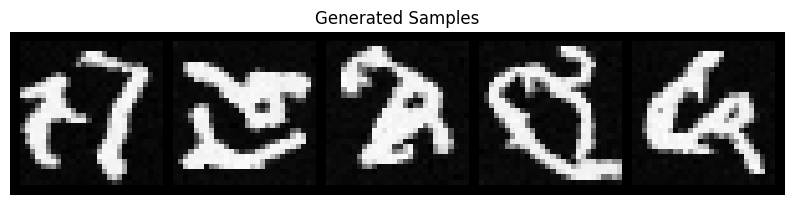

  Step 600/750, Loss: 0.0437
  Step 700/750, Loss: 0.0609

Training - Epoch 27 average loss: 0.0560
Running validation...
Validation - Epoch 27 average loss: 0.0558
Learning rate: 0.001000

Generating samples for visual progress check...


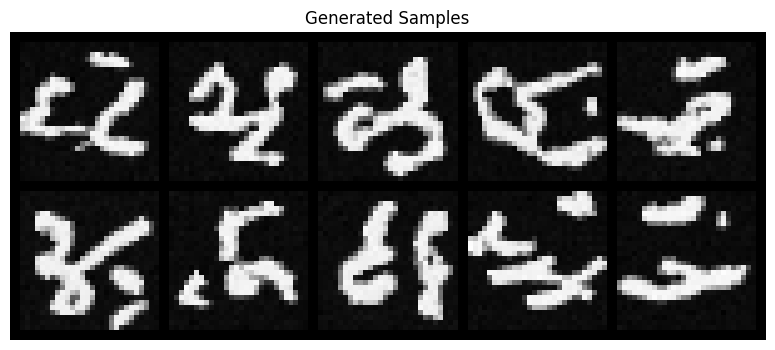

No improvement for 3/10 epochs

Epoch 28/30
--------------------
  Step 0/750, Loss: 0.0596
  Step 100/750, Loss: 0.0625
  Step 200/750, Loss: 0.0531
  Step 300/750, Loss: 0.0561
  Step 400/750, Loss: 0.0528
  Step 500/750, Loss: 0.0563
  Generating samples...


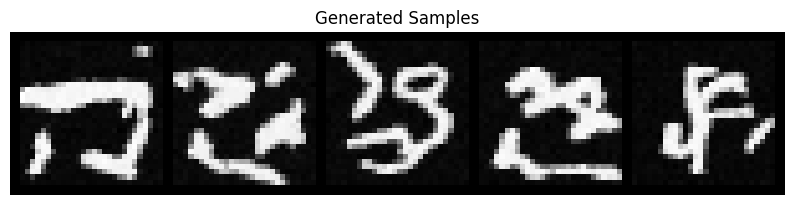

  Step 600/750, Loss: 0.0599
  Step 700/750, Loss: 0.0576

Training - Epoch 28 average loss: 0.0562
Running validation...
Validation - Epoch 28 average loss: 0.0556
Learning rate: 0.001000
No improvement for 4/10 epochs

Epoch 29/30
--------------------
  Step 0/750, Loss: 0.0545
  Step 100/750, Loss: 0.0503
  Step 200/750, Loss: 0.0575
  Step 300/750, Loss: 0.0574
  Step 400/750, Loss: 0.0566
  Step 500/750, Loss: 0.0571
  Generating samples...


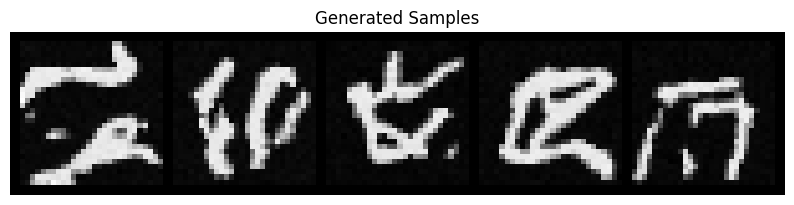

  Step 600/750, Loss: 0.0470
  Step 700/750, Loss: 0.0550

Training - Epoch 29 average loss: 0.0562
Running validation...
Validation - Epoch 29 average loss: 0.0569
Learning rate: 0.001000

Generating samples for visual progress check...


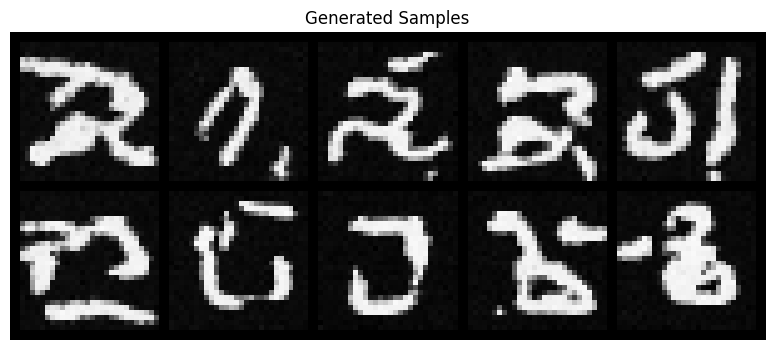

No improvement for 5/10 epochs

Epoch 30/30
--------------------
  Step 0/750, Loss: 0.0546
  Step 100/750, Loss: 0.0626
  Step 200/750, Loss: 0.0529
  Step 300/750, Loss: 0.0622
  Step 400/750, Loss: 0.0557
  Step 500/750, Loss: 0.0609
  Generating samples...


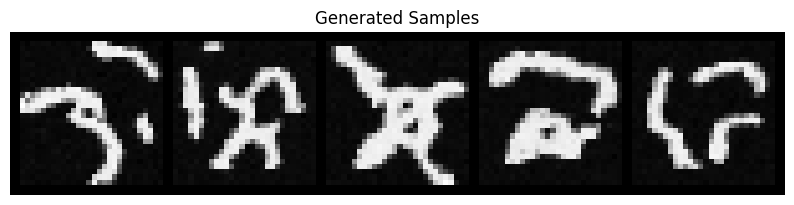

  Step 600/750, Loss: 0.0583
  Step 700/750, Loss: 0.0540

Training - Epoch 30 average loss: 0.0559
Running validation...
Validation - Epoch 30 average loss: 0.0562
Learning rate: 0.000500

Generating samples for visual progress check...


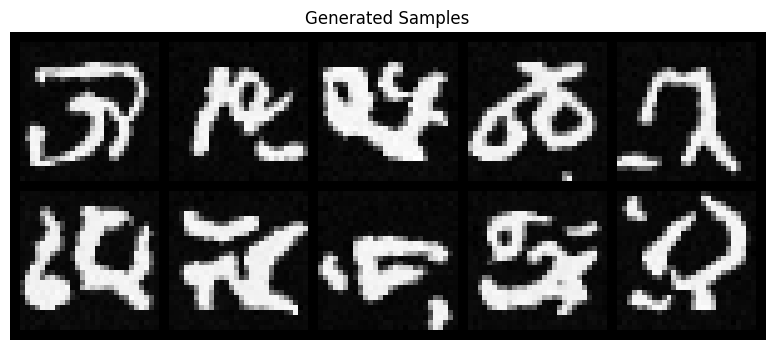

No improvement for 6/10 epochs


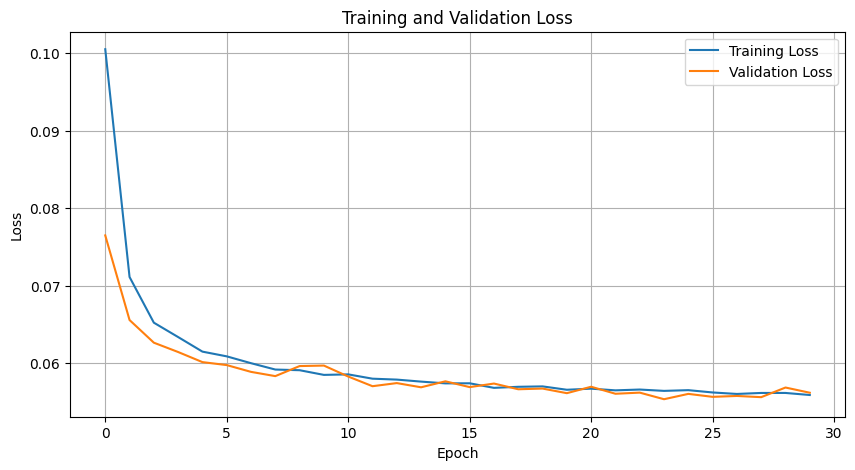


TRAINING COMPLETE
Best validation loss: 0.0553
Generating final samples...


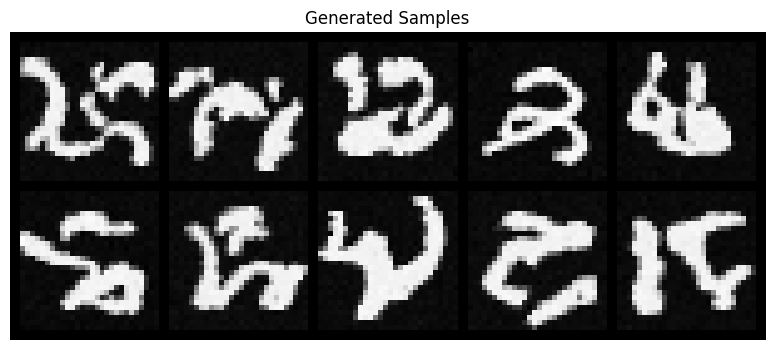

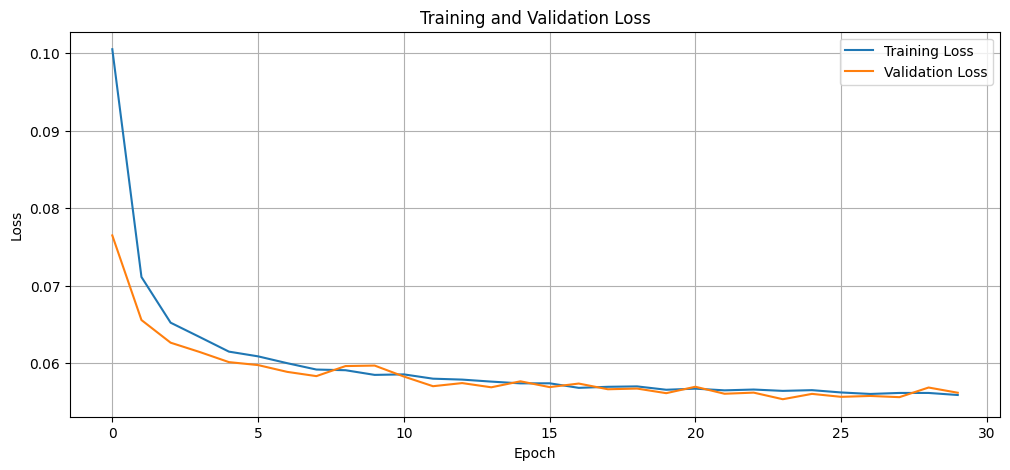

In [ ]:
# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100
generate_frequency = 500

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
model.train()

try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        for step, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5)

        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():
            for val_images, val_labels in val_dataloader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss)
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

except Exception as e:
    print(f"\nError during training: {e}")
    torch.cuda.empty_cache()

# Final wrap-up
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Best validation loss: {best_loss:.4f}")

# Generate final samples
print("Generating final samples...")
generate_samples(model, n_samples=10)

# Display final loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Clean up memory
torch.cuda.empty_cache()

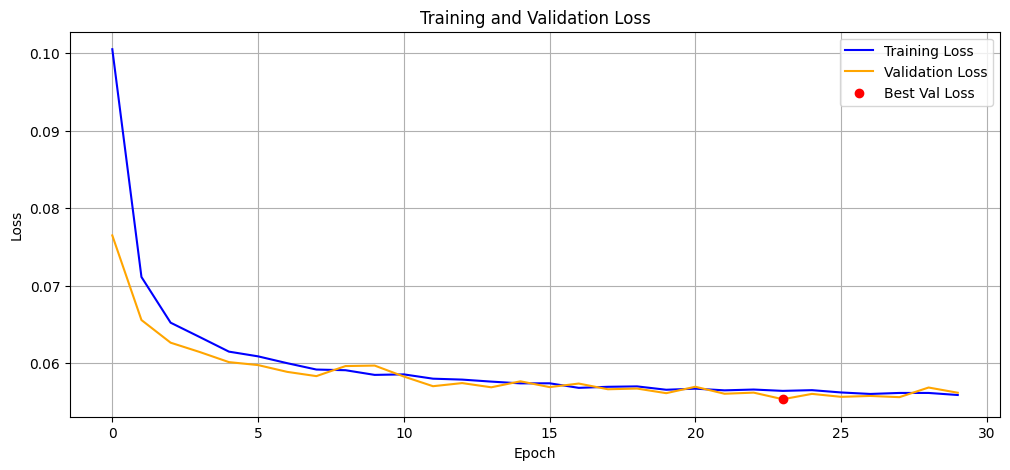

In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
# Mark the best validation loss
if val_losses:
    best_epoch = val_losses.index(min(val_losses))
    plt.scatter(best_epoch, min(val_losses), color='red', label='Best Val Loss', zorder=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

Generating 4 versions of number 0...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 1...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 2...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 3...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 4...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 

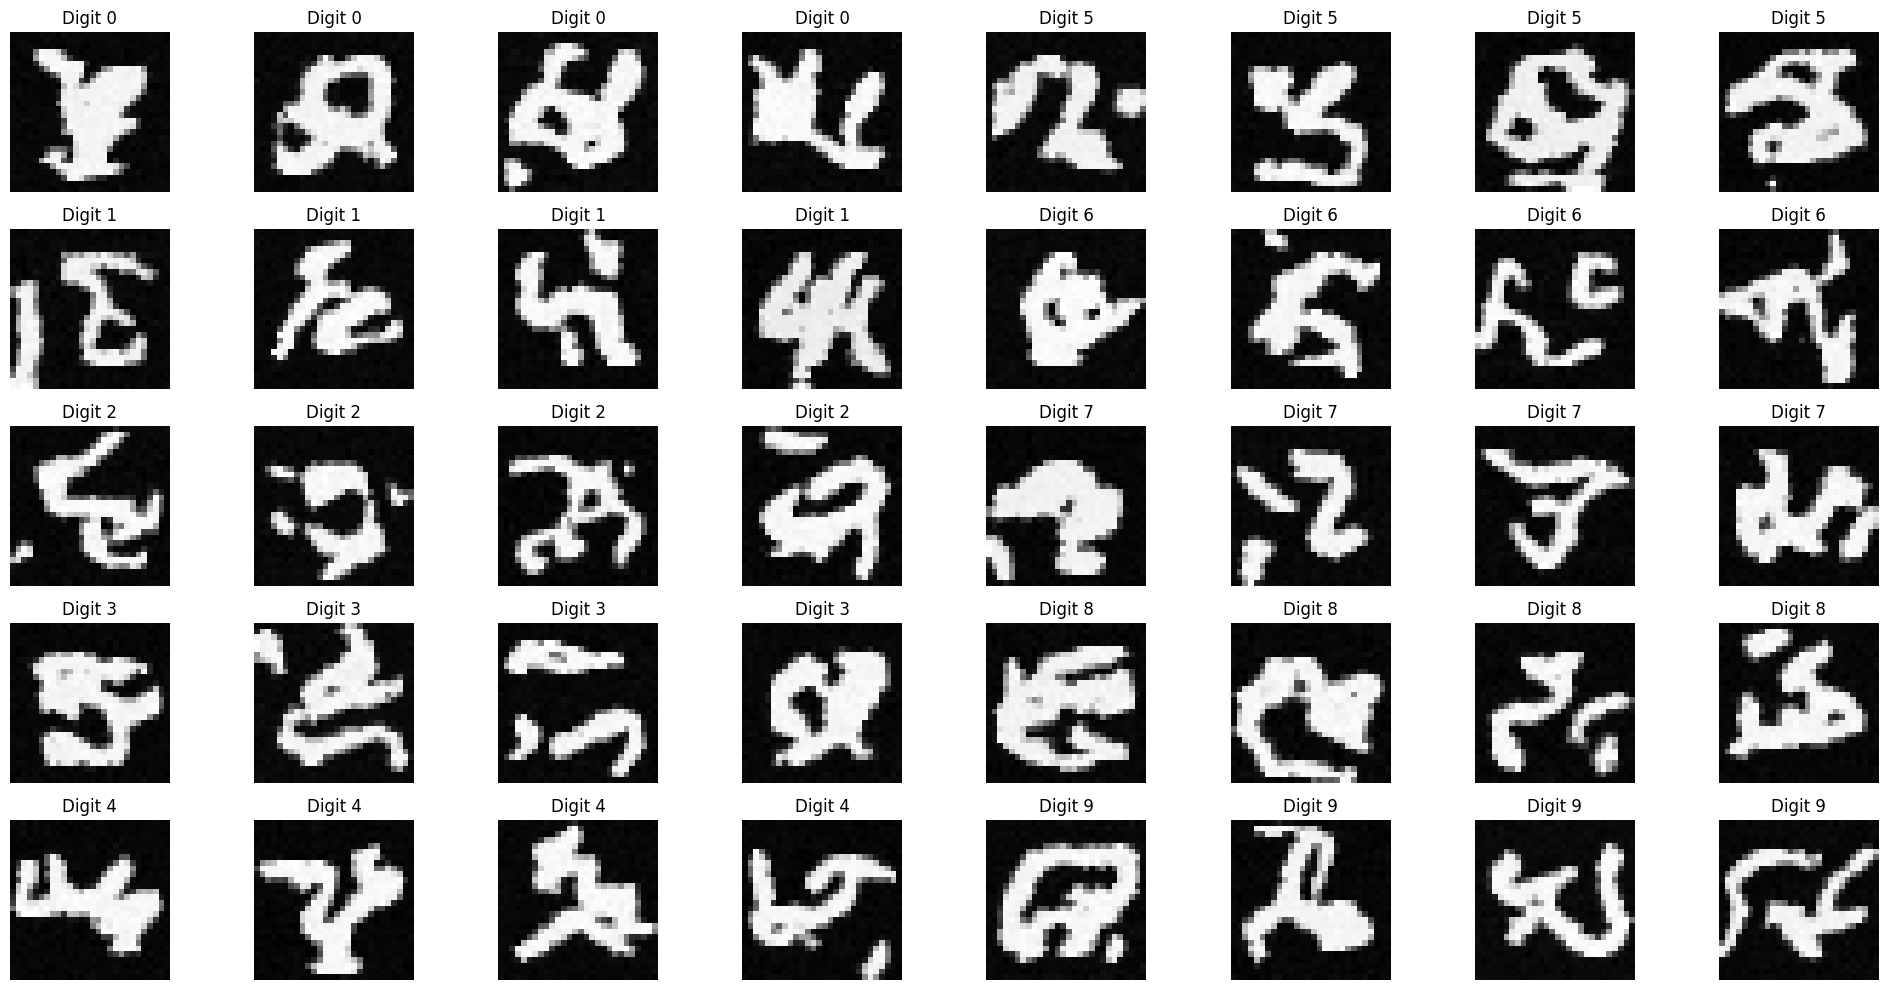


STUDENT ACTIVITY: Generating numbers with different noise seeds
Generating 10 versions of number 5...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


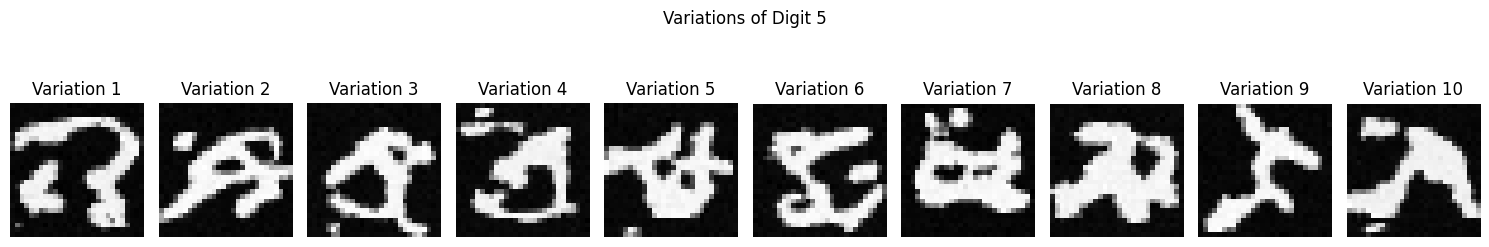

In [ ]:
def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            samples = remove_noise(samples, t_batch, model, c_one_hot, c_mask)

            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
plt.figure(figsize=(20, 10))
for i in range(10):
    # Generate samples for current digit
    samples = generate_number(model, i, n_samples=4)

    # Display each sample
    for j in range(4):
        # Use 2 rows, 10 digits per row, 4 samples per digit
        # i//5 determines the row (0 or 1)
        # i%5 determines the position in the row (0-4)
        # j is the sample index within each digit (0-3)
        plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)

        # Display the image correctly based on channel configuration
        if IMG_CH == 1:  # Grayscale
            plt.imshow(samples[j][0].cpu(), cmap='gray')
        else:  # Color image
            img = samples[j].permute(1, 2, 0).cpu()
            # Rescale from [-1, 1] to [0, 1] if needed
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)

        plt.title(f'Digit {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Generating numbers with different noise seeds")

# Helper function to generate with seed
def generate_with_seed(number, seed_value=42, n_samples=10):
    torch.manual_seed(seed_value)
    return generate_number(model, number, n_samples)

# Pick a digit and show many variations
digit_to_generate = 5  # Let's generate variations of digit 5
n_variations = 10  # Number of variations to generate
variations = generate_with_seed(digit_to_generate, seed_value=42, n_samples=n_variations)

# Display the variations
plt.figure(figsize=(15, 3))
for j in range(n_variations):
    plt.subplot(1, n_variations, j + 1)
    if IMG_CH == 1:  # Grayscale
        plt.imshow(variations[j][0].cpu(), cmap='gray')
    else:  # Color image
        img = variations[j].permute(1, 2, 0).cpu()
        if img.min() < 0:
            img = (img + 1) / 2
        plt.imshow(img)
    plt.title(f'Variation {j+1}')
    plt.axis('off')
plt.suptitle(f'Variations of Digit {digit_to_generate}')
plt.tight_layout()
plt.show()

## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!


Visualizing generation process for digit 0:


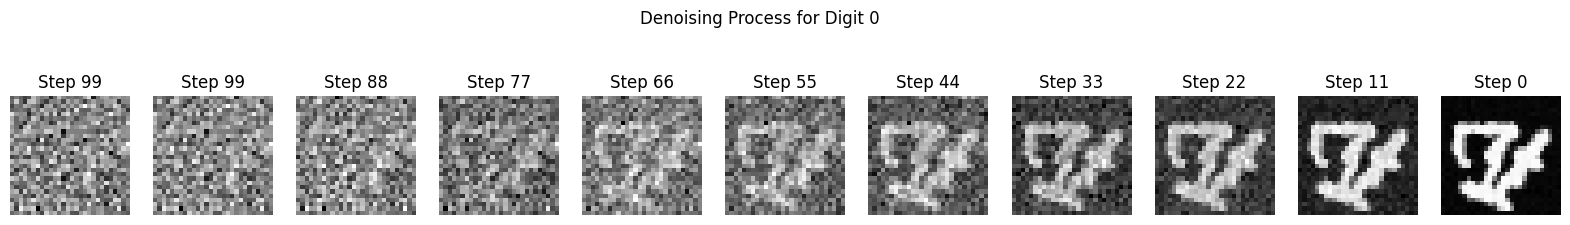


Visualizing generation process for digit 3:


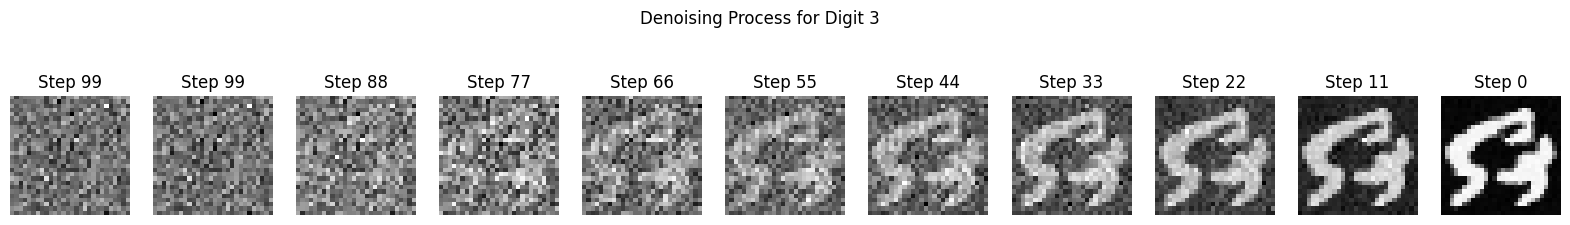


Visualizing generation process for digit 7:


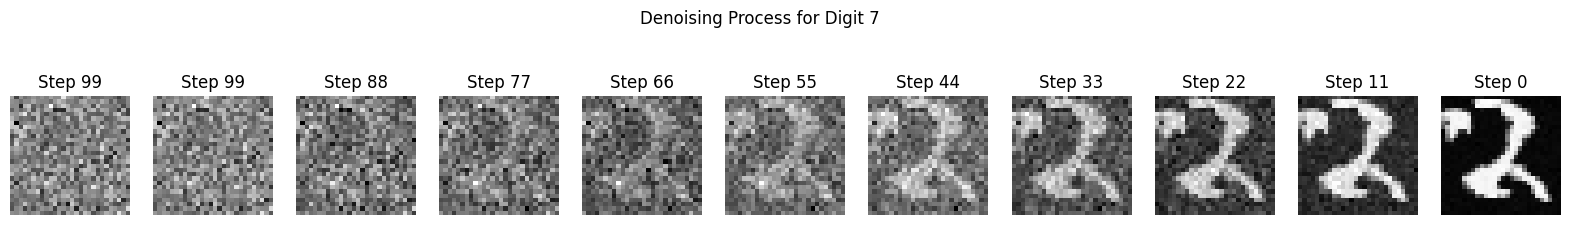

In [ ]:
def visualize_generation_steps(model, number, n_preview_steps=10):
    """
    Show how an image evolves from noise to a clear number
    """
    model.eval()
    with torch.no_grad():
        # Start with random noise
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up which number to generate
        c = torch.tensor([number]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)  # Shape: [1, 1]

        # Calculate which steps to show
        steps_to_show = torch.linspace(n_steps-1, 0, n_preview_steps).long()

        # Store images for visualization
        images = []
        images.append(x[0].cpu())

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            if t in steps_to_show:
                images.append(x[0].cpu())

        # Show the progression
        plt.figure(figsize=(20, 3))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i+1)
            if IMG_CH == 1:
                plt.imshow(img[0], cmap='gray')
            else:
                img = img.permute(1, 2, 0)
                if img.min() < 0:
                    img = (img + 1) / 2
                plt.imshow(img)
            step = steps_to_show[i-1] if i > 0 else n_steps-1
            plt.title(f'Step {int(step)}')
            plt.axis('off')
        plt.suptitle(f'Denoising Process for Digit {number}')
        plt.show()

# Show generation process for a few numbers
for number in [0, 3, 7]:
    print(f"\nVisualizing generation process for digit {number}:")
    visualize_generation_steps(model, number)

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [ ]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Check if CLIP is already installed
    print("Checking if CLIP is already installed...")
    import clip
    models = clip.available_models()
    print(f"✓ CLIP is already installed! Available models: {models}")
    clip_available = True

except ImportError:
    try:
        # Install dependencies first - these help CLIP process text and images
        print("Installing CLIP dependencies...")
        !pip install -q ftfy regex tqdm

        # Install CLIP from GitHub
        print("Installing CLIP from GitHub repository...")
        !pip install -q git+https://github.com/openai/CLIP.git

        # In Colab, we may need to restart the runtime after installing CLIP
        print("Restarting Colab runtime to load CLIP...")
        import os
        os.kill(os.getpid(), 9)  # This will restart the runtime

    except Exception as e:
        print(f"❌ Error during CLIP installation: {e}")
        print("Proceeding without CLIP...")

# After restart, re-import and verify CLIP
try:
    print("Importing CLIP after restart...")
    import clip
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F

print("CLIP setup complete!")

Setting up CLIP (Contrastive Language-Image Pre-training) model...
Checking if CLIP is already installed...
✓ CLIP is already installed! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Importing CLIP after restart...
✓ CLIP installation successful! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

CLIP is now available for evaluating your generated images!
CLIP setup complete!


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [ ]:
import functools
import torch

def manage_gpu_memory(func):
    """
    Decorator to manage GPU memory for functions that might use large amounts of GPU memory.
    Clears the GPU cache before and after the function runs.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                result = func(*args, **kwargs)
                return result
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.0MiB/s]


✓ Successfully loaded CLIP model: VisionTransformer
Generating 4 versions of number 0...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


<ipython-input-31-170c3026f4cf>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


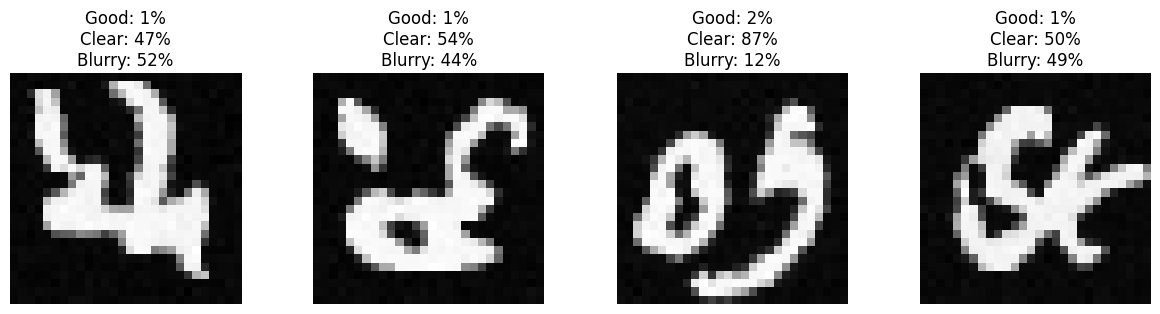

In [ ]:
import torch
import torch.nn.functional as F
import clip
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP model with error handling
clip_available = True
try:
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    print("CLIP evaluation will be skipped. Generated images will still be displayed without scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Evaluate generated images using CLIP by comparing them to text descriptions.

    Args:
        images (torch.Tensor): Batch of images [batch_size, channels, height, width]
        target_number (int): Digit (0-9) the images should represent
        max_batch_size (int): Max images to process at once (memory management)

    Returns:
        torch.Tensor: Scores [batch_size, 3] for [good digit, clear digit, blurry digit]
    """
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        return torch.ones(len(images), 3).to(device) / 3

    try:
        if len(images) > max_batch_size:
            all_similarities = []
            for i in range(0, len(images), max_batch_size):
                batch = images[i:i + max_batch_size]
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)
                torch.cuda.empty_cache()
            return torch.cat(all_similarities, dim=0)
        else:
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        print(f"❌ Error in CLIP evaluation: {e}")
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Compute CLIP similarity scores for a batch of images.

    Args:
        images (torch.Tensor): Batch of images to process
        target_number (int): Target digit for text prompts

    Returns:
        torch.Tensor: Similarity scores for each image
    """
    # Define text prompts
    text_inputs = torch.cat([
        clip.tokenize(f"A handwritten number {target_number}"),
        clip.tokenize(f"A clear, well-written digit {target_number}"),
        clip.tokenize(f"A blurry or unclear number")
    ]).to(device)

    # Preprocess images (convert grayscale to RGB if needed)
    if images.shape[1] == 1:  # Grayscale
        images_rgb = images.repeat(1, 3, 1, 1)
    else:
        images_rgb = images

    # Normalize images to [0, 1] if needed
    if images_rgb.min() < 0:
        images_rgb = (images_rgb + 1) / 2

    # Resize to CLIP input size (224x224)
    resized_images = F.interpolate(images_rgb, size=(224, 224), mode='bilinear', align_corners=False)

    # Encode images and text
    image_features = clip_model.encode_image(resized_images)
    text_features = clip_model.encode_text(text_inputs)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute similarity scores
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarity

# Example usage: Generate and evaluate samples for digit 0
# Replace 'generate_number' with your actual image generation function
samples = generate_number(model, 0, n_samples=4)  # Example placeholder
similarities = evaluate_with_clip(samples, 0)

# Visualize the results
plt.figure(figsize=(15, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(samples[i][0].cpu(), cmap='gray')
    good, clear, blurry = [similarities[i][j].item() * 100 for j in range(3)]
    plt.title(f'Good: {good:.0f}%\nClear: {clear:.0f}%\nBlurry: {blurry:.0f}%')
    plt.axis('off')
plt.show()

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges

Assessment Questions

1. Understanding Diffusion
What happens during the forward diffusion process?
The forward diffusion process slowly adds noise to an image over many steps. Imagine starting with a clear handwritten digit, like a "5," and then adding tiny bits of static to it, step by step, until it looks like complete randomness—just like old-school TV static.

In my experiment, I visualized this process, and I saw how a clear number became blurry and then turned into something unrecognizable. The key is that we don’t just dump all the noise at once, or the model wouldn’t be able to learn how to reverse the process.

Why do we add noise gradually instead of all at once?
If we added all the noise in one step, the model would have no clue how the original image looked. Gradual noise lets the model learn patterns in how digits transform, making it easier to recover them during the reverse process. Think of it like a step-by-step puzzle rather than dumping pieces everywhere and trying to solve it instantly.

At what point can we first recognize the image?
Looking at the step-by-step visualization, I noticed that around 50-60% through the denoising process, I could start to recognize the number again. The clearer digits (like "0" and "1") became visible earlier, while more complex shapes (like "5" and "8") took longer. Yes, it varied by image, and some numbers remained weirdly distorted even near the end.

2. Model Architecture
Why is the U-Net architecture good for diffusion models?
U-Net is awesome for this because it compresses the image down to a smaller version (called an encoding) and then rebuilds it step by step while keeping track of important features. It’s perfect for diffusion because it allows the model to learn how to remove noise without losing important details.

What are skip connections and why do we need them?
Skip connections let the model copy details from earlier layers and bring them back later. This is super helpful because if we only used deep layers, we might lose important features like small curves in digits. The skip connections help recover these missing details, making the images sharper.

How does class conditioning work?
Class conditioning tells the model which digit it should generate. Instead of just making random numbers, we attach a label to guide the model. It does this by encoding the digit label into a format the model can understand and injecting it into the network at multiple points.

3. Training Analysis
What does the loss value tell us?
The loss value tells us how far off the model’s predictions are from the actual noise it should be removing. If the loss is high, the model is struggling to learn. As training continues, the loss should drop, meaning the model is getting better at reconstructing images.

How did image quality change over time?
At first, the generated images looked like random blobs. Around the halfway point in training, I noticed that numbers started to take shape, though some were still messy or weirdly shaped. By the final epochs, most digits looked solid, though certain numbers (like "5") were still hit-or-miss.

Why do we need time embedding?
Time embedding helps the model know where it is in the denoising process. If the model didn’t know what step it was on, it wouldn’t know how much noise to remove or what details to bring back. It’s like a progress tracker guiding the model through the reverse diffusion steps.

4. CLIP Evaluation
What do the CLIP scores tell us?
CLIP scores measure how well the generated digits match real handwritten numbers. Some numbers got high scores for looking clear and realistic, while others were ranked as blurry or poorly formed.

Which images got the highest and lowest scores?
Highest: "0" and "1" had the best scores because they’re simple and easy to recognize.

Lowest: "5" and "8" were the worst. The model seemed to confuse them, and sometimes they looked like random symbols instead of numbers.

Why are some numbers harder to generate?
I think some digits are trickier because they have more curves or look similar to other numbers. For example, "5" and "3" share similar shapes, so the model sometimes blended them weirdly.

How could CLIP scores help improve the model?
One way to use CLIP scores to improve the model is by filtering out bad generations. If CLIP gives a low score, we could tell the model to retry or fine-tune it on those weak areas. Another idea is to train CLIP alongside the diffusion model so it can help correct bad images in real time.

5. Practical Applications
How could this model be useful in the real world?
Handwriting Recognition: Could help digitize handwritten notes or signatures.

Art & Design: Artists could use it to generate sketches and modify them with AI.

Medical Imaging: Could clean up blurry X-rays or MRI scans by reversing noise.

What are its biggest limitations?
Struggles with certain shapes (like "5" and "8").

Slow to train—it took me two full days and I even had to pay for extra runtime.

Some images turned into Chinese-like symbols instead of numbers, so the model isn’t perfect.

Three improvements I’d make
Train on more diverse handwriting → This would help the model handle different styles better.

Use a bigger U-Net with more layers → Could improve the detail of numbers, but it would take longer to train.

Let CLIP guide training → Instead of just scoring images, CLIP could help the model learn to correct bad images.

Bonus Challenge: Experiment Ideas
Modify the U-Net: Add more layers and increase channels. I’d test if this makes images sharper or just slows training down.

CLIP-Guided Selection: Generate 10 versions of each digit, let CLIP pick the best 3, and analyze why they scored higher.

Style Conditioning: Teach the model to generate slanted, bold, or cursive digits, then compare results.

Final Thoughts
This lab was really challenging but also super cool. I learned how diffusion models work, got a taste of U-Net, and used CLIP to judge AI-generated images. The best part was seeing how noise turned into recognizable numbers. If I had more time, I’d fine-tune the model on tricky numbers and try out different conditioning methods.
